In [122]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sonnia.processing import Processing
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Reshape, Activation
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Concatenate
from sklearn.decomposition import PCA

from keras import backend as K
import keras
from keras import losses
from tensorflow.python.framework.ops import disable_eager_execution
from vampire_custom_keras import BetaWarmup, EmbedViaMatrix
from keras import regularizers
from keras.layers.core import Dropout

disable_eager_execution()

# Select dataset

In [123]:
df = pd.read_csv('peptide-detail-ci_filtered_aligned_merged.csv')
df["Amino Acids 1"] = df["Amino Acids"].apply(lambda x: x.split(",")[0])
df

,CDR3,CDR3_al,tokenized_smiles,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome,v_gene,j_gene,Amino Acids 1
0,CASSAQGTGDRGYTF,CASSA-----QGTGDRGYTF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 27, 13]",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ01-02,ADAGFIKQY
1,CASSLVATGNTGELFF,CASSL----VATGNTGELFF,"[12, 16, 34, 34, 31, 31, 31, 31, 23, 27, 27, 13]",CASSLVATGNTGELFF+TCRBV07-09+TCRBJ02-02,CGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCT...,eOX56,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV07-09,TCRBJ02-02,ADAGFIKQY
2,CALKVGADTQYF,CALKV--------GADTQYF,"[12, 16, 31, 31, 31, 31, 31, 31, 31, 31, 27, 13]",CALKVGADTQYF+TCRBV30-01+TCRBJ02-03,CTGAGTTCTAAGAAGCTCCTTCTCAGTGACTCTGGCTTCTATCTCT...,eQD124,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV30-01,TCRBJ02-03,ADAGFIKQY
3,CASSLWASGRGGTGELFF,CASSLW--ASGRGGTGELFF,"[12, 16, 34, 34, 31, 31, 34, 27, 27, 13]",CASSLWASGRGGTGELFF+TCRBV27-01+TCRBJ02-02,AGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTTTATGGG...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ02-02,ADAGFIKQY
4,CASSLLGWEQLDEQFF,CASSL----LGWEQLDEQFF,"[12, 16, 34, 34, 31, 31, 31, 31, 27, 27, 13]",CASSLLGWEQLDEQFF+TCRBV27-01+TCRBJ02-01,TCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTT...,eMR16,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ02-01,ADAGFIKQY
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236340,CASSSGPQETQYF,CASSS-------GPQETQYF,"[12, 16, 34, 34, 34, 31, 31, 31, 31, 31, 31, 3...",CASSSGPQETQYF+TCRBV07-09+TCRBJ02-05,GAGATCCAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTG...,eAV88,ORF10,"AQVDVVNFNL,NYIAQVDVV",29630,29668,TCRBV07-09,TCRBJ02-05,AQVDVVNFNL
236341,CASSKRDSQETQYF,CASSK------RDSQETQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSKRDSQETQYF+TCRBV07-09+TCRBJ02-05,ATCCAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCA...,eDH105,ORF10,"AQVDVVNFNL,NYIAQVDVV",29630,29668,TCRBV07-09,TCRBJ02-05,AQVDVVNFNL
236342,CASSQLPGQGKVQYF,CASSQ-----LPGQGKVQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 45, 27, 13]",CASSQLPGQGKVQYF+TCRBV04-01+TCRBJ02-07,CACGCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCGCCAGCA...,eAV93,ORF10,"AQVDVVNFNL,NYIAQVDVV",29630,29668,TCRBV04-01,TCRBJ02-07,AQVDVVNFNL
236343,CASSPGDNEQFF,CASSP--------GDNEQFF,"[12, 16, 34, 34, 45, 31, 31, 31, 31, 31, 31, 3...",CASSPGDNEQFF+TCRBV09-01+TCRBJ02-01,CTAAACCTGAGCTCTCTGGAGCTGGGGGACTCAGCTTTGTATTTCT...,eEE224,ORF10,"AQVDVVNFNL,NYIAQVDVV",29630,29668,TCRBV09-01,TCRBJ02-01,AQVDVVNFNL


In [4]:
to_keep = ["FFSNVTWFH", "AFLLFLVLI", "LSPRWYFYY"]
df = df[df["Amino Acids 1"].isin(to_keep)]
df

,CDR3,CDR3_al,tokenized_smiles,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome,v_gene,j_gene,Amino Acids 1
121,CASSLTGGTEAFF,CASSL-------TGGTEAFF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 31, 2...",CASSLTGGTEAFF+TCRBV05-01+TCRBJ01-01,AATGTGAGCACCTTGGAGCTGGGGGACTCGGCCCTTTATCTTTGCG...,eXL30,ORF7b,"AFLLFLVLI,FLAFLLFLV,FYLCFLAFL,FYLCFLAFLL,IDFYL...",27756,27830,TCRBV05-01,TCRBJ01-01,AFLLFLVLI
122,CASSLTGGTEAFF,CASSL-------TGGTEAFF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 31, 2...",CASSLTGGTEAFF+TCRBV11-03+TCRBJ01-01,AAGATCCAGCCTGCAGAGCTTGGGGACTCGGCCGTGTATCTCTGTG...,eOX46,ORF7b,"AFLLFLVLI,FLAFLLFLV,FYLCFLAFL,FYLCFLAFLL,IDFYL...",27756,27830,TCRBV11-03,TCRBJ01-01,AFLLFLVLI
125,CASSLTGGTEAFF,CASSL-------TGGTEAFF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 31, 2...",CASSLTGGTEAFF+TCRBV05-01+TCRBJ01-01,AATGTGAGCACCTTGGAGCTGGGGGACTCGGCCCTTTATCTTTGCG...,eXL30,ORF7b,"AFLLFLVLI,FLAFLLFLV,FYLCFLAFL,FYLCFLAFLL,IDFYL...",27756,27830,TCRBV05-01,TCRBJ01-01,AFLLFLVLI
126,CASSLTGGTEAFF,CASSL-------TGGTEAFF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 31, 2...",CASSLTGGTEAFF+TCRBV11-03+TCRBJ01-01,AAGATCCAGCCTGCAGAGCTTGGGGACTCGGCCGTGTATCTCTGTG...,eOX46,ORF7b,"AFLLFLVLI,FLAFLLFLV,FYLCFLAFL,FYLCFLAFLL,IDFYL...",27756,27830,TCRBV11-03,TCRBJ01-01,AFLLFLVLI
129,CASSLTGGTEAFF,CASSL-------TGGTEAFF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 31, 2...",CASSLTGGTEAFF+TCRBV05-01+TCRBJ01-01,AATGTGAGCACCTTGGAGCTGGGGGACTCGGCCCTTTATCTTTGCG...,eXL30,ORF7b,"AFLLFLVLI,FLAFLLFLV,FYLCFLAFL,FYLCFLAFLL,IDFYL...",27756,27830,TCRBV05-01,TCRBJ01-01,AFLLFLVLI
...,...,...,...,...,...,...,...,...,...,...,...,...,...
233774,CASSQGSDTQYF,CASSQ--------GSDTQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 31, 3...",CASSQGSDTQYF+TCRBV03-01/03-02+TCRBJ02-03,CTTCACATCAATTCCCTGGAGCTTGGTGACTCTGCTGTGTATTTCT...,eOX46,ORF7b,"AFLLFLVLI,FLAFLLFLV,FYLCFLAFL,FYLCFLAFLL,IDFYL...",27756,27830,TCRBV03-01/03-02,TCRBJ02-03,AFLLFLVLI
233777,CASSQGSDTQYF,CASSQ--------GSDTQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 31, 3...",CASSQGSDTQYF+TCRBV03-01/03-02+TCRBJ02-03,CTTCACATCAATTCCCTGGAGCTTGGTGACTCTGCTGTGTATTTCT...,eOX46,ORF7b,"AFLLFLVLI,FLAFLLFLV,FYLCFLAFL,FYLCFLAFLL,IDFYL...",27756,27830,TCRBV03-01/03-02,TCRBJ02-03,AFLLFLVLI
234157,CASSRGGNEQFF,CASSR--------GGNEQFF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 31, 3...",CASSRGGNEQFF+TCRBV03-01/03-02+TCRBJ02-01,CTTCACATCAATTCCCTGGAGCTTGGTGACTCTGCTGTGTATTTCT...,eXL31,ORF7b,"AFLLFLVLI,FLAFLLFLV,FYLCFLAFL,FYLCFLAFLL,IDFYL...",27756,27830,TCRBV03-01/03-02,TCRBJ02-01,AFLLFLVLI
234160,CASSRGGNEQFF,CASSR--------GGNEQFF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 31, 3...",CASSRGGNEQFF+TCRBV03-01/03-02+TCRBJ02-01,CTTCACATCAATTCCCTGGAGCTTGGTGACTCTGCTGTGTATTTCT...,eXL31,ORF7b,"AFLLFLVLI,FLAFLLFLV,FYLCFLAFL,FYLCFLAFLL,IDFYL...",27756,27830,TCRBV03-01/03-02,TCRBJ02-01,AFLLFLVLI


In [124]:

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

aa = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q","R", "S", "T", "V", "W", "Y", "-"]

# integer encode
label_encoder = LabelEncoder()
y_encoder =LabelEncoder()
y_encoder = y_encoder.fit(df['Amino Acids'].unique())
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = label_encoder.fit_transform(aa)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit(integer_encoded)


/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [125]:
one_hot_status = True
col_one_hot = []
col_integer = []
y_labels = []
for k in tqdm(df.index):
    integer_encoded = label_encoder.transform(list(df.loc[k,"CDR3_al"]))
    col_integer.append(integer_encoded)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    if one_hot_status:
        onehot_encoded = onehot_encoder.transform(integer_encoded)
        col_one_hot.append(onehot_encoded)
    y_label = y_encoder.transform([df.loc[k,"Amino Acids"]])
    y_labels.append(y_label)
    

  0%|          | 0/236345 [00:00<?, ?it/s]

In [126]:
def encode_cdr3_seqs(cdr3_seqs, labelencoder, onehotencoder, onehot=True):
    """Encode CDR3 sequences to one-hot encoding."""
    encoded_seqs = []
    for cdr3 in cdr3_seqs:
        integer_encoded = labelencoder.transform(list(cdr3))
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        if onehot:
            onehot_encoded = onehotencoder.transform(integer_encoded)
            encoded_seqs.append(onehot_encoded)
        else:
            encoded_seqs.append(integer_encoded)
    return encoded_seqs

col_one_hot = encode_cdr3_seqs(df["CDR3_al"], label_encoder, onehot_encoder, onehot=True)

In [127]:
y_labels = [int(y) for y in y_labels]
if one_hot_status:
    df["CDR3_al_one_hot"] = col_one_hot
df["CDR3_al_integer"] = col_integer
df["label"] = y_labels

In [128]:
v_labels = []
v_encoder = LabelEncoder()
v_encoder_one_hot = OneHotEncoder(sparse=False)
v_encoder = v_encoder.fit(df['v_gene'].unique())
v_encoder_one_hot = v_encoder_one_hot.fit(v_encoder.transform(df['v_gene'].unique()).reshape(-1,1))
for k in tqdm(df.index):
    v_label = v_encoder.transform([df.loc[k,"v_gene"]])
    v_label = v_encoder_one_hot.transform(v_label.reshape(-1,1))
    v_labels.append(v_label)
df["v_gene_one_hot"] = v_labels

j_labels = []
j_encoder = LabelEncoder()
j_encoder_one_hot = OneHotEncoder(sparse=False)
j_encoder = j_encoder.fit(df['j_gene'].unique())
j_encoder_one_hot = j_encoder_one_hot.fit(j_encoder.transform(df['j_gene'].unique()).reshape(-1,1))
for k in tqdm(df.index):
    j_label = j_encoder.transform([df.loc[k,"j_gene"]])
    j_label = j_encoder_one_hot.transform(j_label.reshape(-1,1))
    j_labels.append(j_label)
df["j_gene_one_hot"] = j_labels

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


  0%|          | 0/236345 [00:00<?, ?it/s]

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


  0%|          | 0/236345 [00:00<?, ?it/s]

In [129]:
len_j_gene = len(j_encoder.classes_)
len_v_gene = len(v_encoder.classes_)
print(len_j_gene, len_v_gene)

13 54


In [130]:
df = df.sample(frac=1).reset_index(drop=True)
data = df[['CDR3_al_one_hot', 'v_gene_one_hot', 'j_gene_one_hot']]
data["v_gene_one_hot"]  = data["v_gene_one_hot"].apply(lambda x: x.reshape(len_v_gene,))
data["j_gene_one_hot"]  = data["j_gene_one_hot"].apply(lambda x: x.reshape(len_j_gene,))
data = [np.stack(col.values) for _, col in data.items()]
#X_train = tf.constant(df["CDR3"].to_numpy())
#X_train_v_gene = tf.constant(df["v_gene"].to_numpy())
#X_train_j_gene = tf.constant(df["j_gene"].to_numpy())
X_train = data

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_26631/652920261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["v_gene_one_hot"]  = data["v_gene_one_hot"].apply(lambda x: x.reshape(len_v_gene,))
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_26631/652920261.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["j_gene_one_hot"]  = data["j_gene_one_hot"].apply(lambda x: x.reshape(len_j_gene,))


In [131]:
X_train[0].shape

(236345, 20, 21)

In [132]:
def build(params):

    beta = K.variable(params['beta'])

    def sampling(args):
        """
        This function draws a sample from the multivariate normal defined by
        the latent variables.
        """
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(params['batch_size'], params['latent_dim']), mean=0.0, stddev=1.0)
        print(epsilon.shape)
        # Reparameterization trick!
        return (z_mean + K.exp(z_log_var / 2) * epsilon)

    def vae_cdr3_loss(io_encoder, io_decoder):
        """
        The loss function is the sum of the cross-entropy and KL divergence. KL
        gets a weight of beta.
        """
        # Here we multiply by the number of sites, so that we have a
        # total loss across the sites rather than a mean loss.
        xent_loss = params['max_cdr3_len'] * K.mean(losses.categorical_crossentropy(io_encoder, io_decoder))
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        kl_loss *= beta
        return (xent_loss + kl_loss)

    # Input:
    cdr3_input_shape = (params['max_cdr3_len'], params['n_aas'])
    cdr3_input = Input(shape=cdr3_input_shape, name='cdr3_input')
    v_gene_input = Input(shape=(params['n_v_genes'], ), name='v_gene_input')
    j_gene_input = Input(shape=(params['n_j_genes'], ), name='j_gene_input')

    # Encoding layers:
    cdr3_embedding = EmbedViaMatrix(params['aa_embedding_dim'], name='cdr3_embedding')(cdr3_input)
    cdr3_embedding_flat = Reshape([params['aa_embedding_dim'] * params['max_cdr3_len']],
                                  name='cdr3_embedding_flat')(cdr3_embedding)
    v_gene_embedding = Dense(params['v_gene_embedding_dim'], name='v_gene_embedding')(v_gene_input)
    j_gene_embedding = Dense(params['j_gene_embedding_dim'], name='j_gene_embedding')(j_gene_input)
    merged_embedding = keras.layers.concatenate([cdr3_embedding_flat, v_gene_embedding, j_gene_embedding],
                                                name='merged_embedding')
    encoder_dense_1 = Dense(params['dense_nodes'], activation='elu', kernel_regularizer=regularizers.l2(0.001), name='encoder_dense_1')(merged_embedding)
    encoder_dense_2 = Dense(params['dense_nodes'], activation='elu', kernel_regularizer=regularizers.l2(0.001), name='encoder_dense_2')(encoder_dense_1)
    encoder_dense_3 = Dense(params['dense_nodes'], activation='elu', kernel_regularizer=regularizers.l2(0.001), name='encoder_dense_1')(encoder_dense_2)
    encoder_dense_4 = Dense(params['dense_nodes'], activation='elu', kernel_regularizer=regularizers.l2(0.001), name='encoder_dense_2')(encoder_dense_3)
    # Latent layers:
    z_mean = Dense(params['latent_dim'], name='z_mean')(encoder_dense_2)
    z_log_var = Dense(params['latent_dim'], name='z_log_var')(encoder_dense_2)

    # Decoding layers:
    z_l = Lambda(sampling, output_shape=(params['latent_dim'], ), name='z')
    decoder_dense_1_l = Dense(params['dense_nodes'], activation='elu', name='decoder_dense_1')
    decoder_dense_2_l = Dense(params['dense_nodes'], activation='elu', name='decoder_dense_2')
    cdr3_post_dense_flat_l = Dense(np.array(cdr3_input_shape).prod(), activation='linear', name='cdr3_post_dense_flat')
    cdr3_post_dense_reshape_l = Reshape(cdr3_input_shape, name='cdr3_post_dense')
    cdr3_output_l = Activation(activation='softmax', name='cdr3_output')
    v_gene_output_l = Dense(params['n_v_genes'], activation='softmax', name='v_gene_output')
    j_gene_output_l = Dense(params['n_j_genes'], activation='softmax', name='j_gene_output')

    post_decoder = decoder_dense_2_l(decoder_dense_1_l(z_l([z_mean, z_log_var])))
    cdr3_output = cdr3_output_l(cdr3_post_dense_reshape_l(cdr3_post_dense_flat_l(post_decoder)))
    v_gene_output = v_gene_output_l(post_decoder)
    j_gene_output = j_gene_output_l(post_decoder)

    # Define the decoder components separately so we can have it as its own model.
    z_mean_input = Input(shape=(params['latent_dim'], ))
    decoder_post_decoder = decoder_dense_2_l(decoder_dense_1_l(z_mean_input))
    decoder_cdr3_output = cdr3_output_l(cdr3_post_dense_reshape_l(cdr3_post_dense_flat_l(decoder_post_decoder)))
    decoder_v_gene_output = v_gene_output_l(decoder_post_decoder)
    decoder_j_gene_output = j_gene_output_l(decoder_post_decoder)

    encoder = Model([cdr3_input, v_gene_input, j_gene_input], [z_mean, z_log_var])
    decoder = Model(z_mean_input, [decoder_cdr3_output, decoder_v_gene_output, decoder_j_gene_output])
    vae = Model([cdr3_input, v_gene_input, j_gene_input], [cdr3_output, v_gene_output, j_gene_output])
    vae.compile(
        optimizer="adam",
        loss={
            'cdr3_output': vae_cdr3_loss,
            'v_gene_output': keras.losses.categorical_crossentropy,
            'j_gene_output': keras.losses.categorical_crossentropy,
        },
        loss_weights={
            # Keep the cdr3_output weight to be 1. The weights are relative
            # anyhow, and buried inside the vae_cdr3_loss is a beta weight that
            # determines how much weight the KL loss has. If we keep this
            # weight as 1 then we can interpret beta in a straightforward way.
            "cdr3_output": 1,
            "j_gene_output": 0.1305,
            "v_gene_output": 0.8138
        })

    callbacks = [BetaWarmup(beta, params['beta'], params['warmup_period'])]

    return {'encoder': encoder, 'decoder': decoder, 'vae': vae, 'callbacks': callbacks}

In [133]:
params = {
            "latent_dim": 2,
            "dense_nodes": 75,
            "aa_embedding_dim": 21,
            "v_gene_embedding_dim": len_v_gene,
            "j_gene_embedding_dim": len_j_gene,
            "beta": 0.75,
            "max_cdr3_len": 20,
            "n_aas": 21,
            "n_v_genes": len_v_gene,
            "n_j_genes": len_j_gene,
            "stopping_monitor": "val_loss",
            "batch_size": 50,
            "pretrains": 2,
            "warmup_period": 3,
            "epochs": 4,
            "patience": 20,
            "n_inputs" : 20,
            "v_inputs" : 54,
            "j_inputs" : 13
        }

In [134]:
res = build(params)

(50, 2)


Exception ignored in: <function tqdm.__del__ at 0x7fb588959ee0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [135]:
#keep only first 47000
X_train_2 = X_train.copy()
for i in range(len(X_train)):
    X_train_2[i] = X_train[i][:47000]

In [136]:
history = res["vae"].fit(X_train_2, X_train_2, epochs=50, batch_size=50, verbose=1, validation_split=0.2, callbacks=res["callbacks"]) 

Train on 37600 samples, validate on 9400 samples
Epoch 1/50
37000/37600 [============================>.] - ETA: 0s - loss: 24.0682 - cdr3_output_loss: 21.2262 - v_gene_output_loss: 3.0138 - j_gene_output_loss: 1.6632

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


37600/37600 [==============================] - 3s 67us/sample - loss: 24.0263 - cdr3_output_loss: 21.1870 - v_gene_output_loss: 3.0123 - j_gene_output_loss: 1.6551 - val_loss: 20.9470 - val_cdr3_output_loss: 18.3212 - val_v_gene_output_loss: 2.8604 - val_j_gene_output_loss: 1.1478
Epoch 2/50
37600/37600 [==============================] - 2s 50us/sample - loss: 17.0478 - cdr3_output_loss: 14.5787 - v_gene_output_loss: 2.7143 - j_gene_output_loss: 0.7302 - val_loss: 15.8265 - val_cdr3_output_loss: 13.4584 - val_v_gene_output_loss: 2.6044 - val_j_gene_output_loss: 0.5713
Epoch 3/50
37600/37600 [==============================] - 2s 49us/sample - loss: 17.0756 - cdr3_output_loss: 14.7097 - v_gene_output_loss: 2.6281 - j_gene_output_loss: 0.6067 - val_loss: 16.8022 - val_cdr3_output_loss: 14.4749 - val_v_gene_output_loss: 2.5987 - val_j_gene_output_loss: 0.5570
Epoch 4/50
37600/37600 [==============================] - 2s 49us/sample - loss: 17.5666 - cdr3_output_loss: 15.2252 - v_gene_output

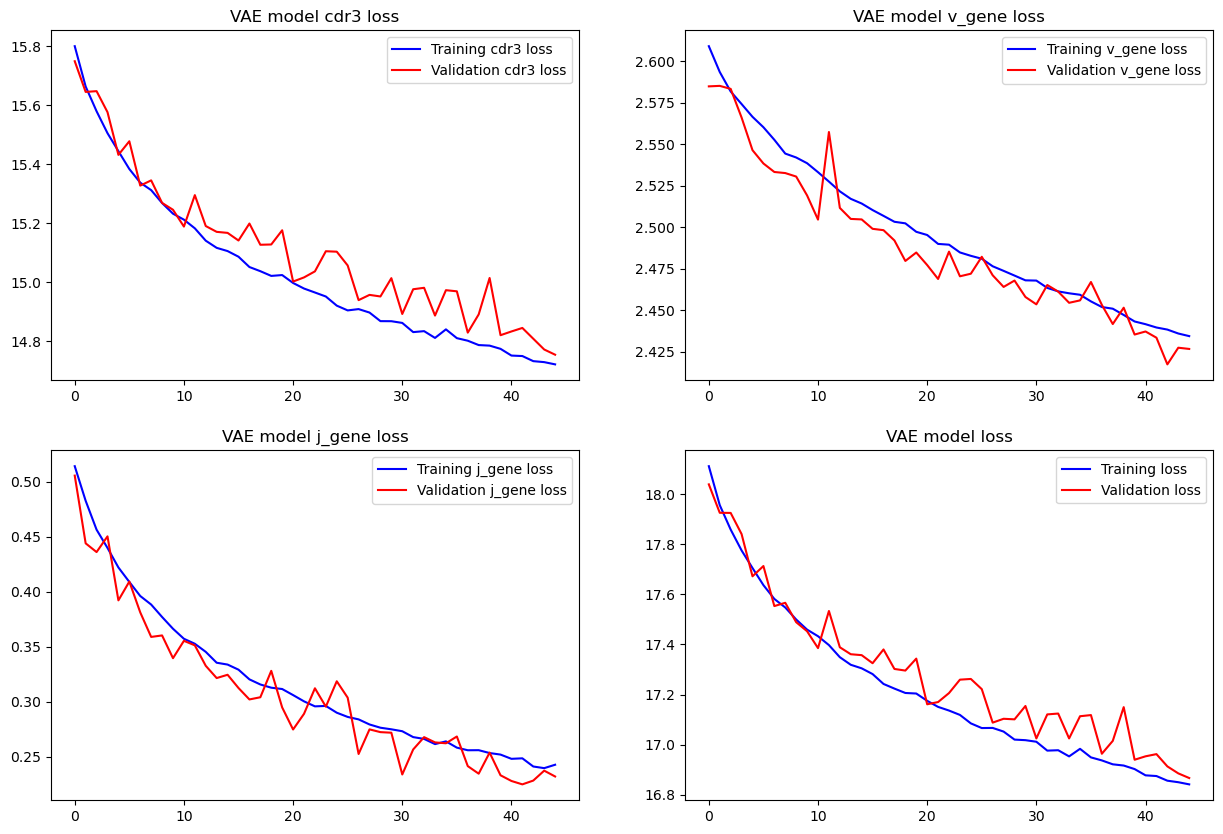

In [137]:
#Plot the history loss of the model with 4 subfigures
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['cdr3_output_loss'][5:], label='Training cdr3 loss', color='blue')
plt.plot(history.history['val_cdr3_output_loss'][5:], label='Validation cdr3 loss', color='red')
plt.title('VAE model cdr3 loss')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(history.history['v_gene_output_loss'][5:], label='Training v_gene loss', color='blue')
plt.plot(history.history['val_v_gene_output_loss'][5:], label='Validation v_gene loss', color='red')
plt.title('VAE model v_gene loss')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(history.history['j_gene_output_loss'][5:], label='Training j_gene loss', color='blue')
plt.plot(history.history['val_j_gene_output_loss'][5:], label='Validation j_gene loss', color='red')
plt.title('VAE model j_gene loss')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(history.history['loss'][5:], label='Training loss', color='blue')
plt.plot(history.history['val_loss'][5:], label='Validation loss', color='red')
plt.title('VAE model loss')
plt.legend()
plt.show()

## Inspect weights (latent nodes features)

In [141]:
# Fix v_gene and j_gene
v_gene_input = np.zeros((1, 54))
j_gene_input = np.zeros((1, 13))
v_gene_input

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

In [142]:
print(X_train_2[1].shape)
print(X_train_2[2].shape)

(47000, 54)
(47000, 13)


In [143]:
# Inspect weights interpretation
encoder = res["encoder"]
decoder = res["decoder"]

store_dict = {}

for letter in aa:
    base_seq = "-" * 20
    for pos in range(20):
        test_seq_str = base_seq[:pos] + letter + base_seq[pos+1:]
        test_seq = encode_cdr3_seqs([test_seq_str], label_encoder, onehot_encoder)
        model_input = [test_seq, v_gene_input, j_gene_input]
        model_input[0] = np.array(model_input[0])
        model_input[1] = model_input[1].reshape(1, 54)
        model_input[2] = model_input[2].reshape(1, 13)
        z_mean, z_log_var = encoder.predict(model_input)
        store_dict[test_seq_str] = z_mean

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [144]:
store_dict
# unnatural sequences -> exisitng sequence and change each letter to another letter (for different base sequences)

{'A-------------------': array([[2.2695692 , 0.35920146]], dtype=float32),
 '-A------------------': array([[1.3818458 , 0.43911844]], dtype=float32),
 '--A-----------------': array([[1.6357464 , 0.45410964]], dtype=float32),
 '---A----------------': array([[1.86403   , 0.48885554]], dtype=float32),
 '----A---------------': array([[2.0626247 , 0.37543288]], dtype=float32),
 '-----A--------------': array([[2.670397  , 0.39918754]], dtype=float32),
 '------A-------------': array([[3.105486  , 0.21537507]], dtype=float32),
 '-------A------------': array([[2.9330473 , 0.21144217]], dtype=float32),
 '--------A-----------': array([[2.7132087 , 0.28440833]], dtype=float32),
 '---------A----------': array([[2.1131153, 0.6666231]], dtype=float32),
 '----------A---------': array([[1.7589154 , 0.30756637]], dtype=float32),
 '-----------A--------': array([[-0.23294342, -1.5446057 ]], dtype=float32),
 '------------A-------': array([[ 2.496863  , -0.17829657]], dtype=float32),
 '-------------A------'

In [145]:
store_dict['A-------------------'][0][0]

2.2695692

In [146]:
# Get most influential letter for each position
vars_pos = {}
for pos in range(20):
    print("Position:", pos)
    pos_list_1 = []
    pos_list_2 = []
    for letter in aa:
        print(letter, store_dict["-" * pos + letter + "-" * (19 - pos)])
        pos_list_1.append(store_dict["-" * pos + letter + "-" * (19 - pos)][0][0])
        pos_list_2.append(store_dict["-" * pos + letter + "-" * (19 - pos)][0][1])

    print("Variance of means latent 1:", np.var(pos_list_1))
    print("Variance of means latent 2:", np.var(pos_list_2))
    vars_pos[pos] = [np.var(pos_list_1), np.var(pos_list_2)]

Position: 0
A [[2.2695692  0.35920146]]
C [[2.2658417  0.35847995]]
D [[2.274372   0.36198997]]
E [[2.26747    0.35982585]]
F [[2.269446  0.3614106]]
G [[2.2627113  0.35895893]]
H [[2.2791002  0.36103743]]
I [[2.2646117  0.36135006]]
K [[2.2681427  0.36334595]]
L [[2.266964   0.35672134]]
M [[2.2736366  0.36081922]]
N [[2.2585044 0.3626362]]
P [[2.268149  0.3576778]]
Q [[2.2698007  0.36200708]]
R [[2.2692506  0.36060524]]
S [[2.267764   0.36178195]]
T [[2.261924  0.3610327]]
V [[2.2693758  0.36091638]]
W [[2.2618368  0.36014196]]
Y [[2.2585409  0.35650966]]
- [[2.26485   0.3548859]]
Variance of means latent 1: 2.402226e-05
Variance of means latent 2: 4.5532083e-06
Position: 1
A [[1.3818458  0.43911844]]
C [[2.0068846  0.41906285]]
D [[1.9138609 0.4279443]]
E [[1.9598391  0.43329984]]
F [[1.953925  0.4465556]]
G [[1.8296179 0.428327 ]]
H [[1.9169912 0.4556706]]
I [[1.8433211  0.46687528]]
K [[1.8125923  0.42140028]]
L [[1.7909776 0.4520222]]
M [[1.8092126  0.43382955]]
N [[1.9290943  0.

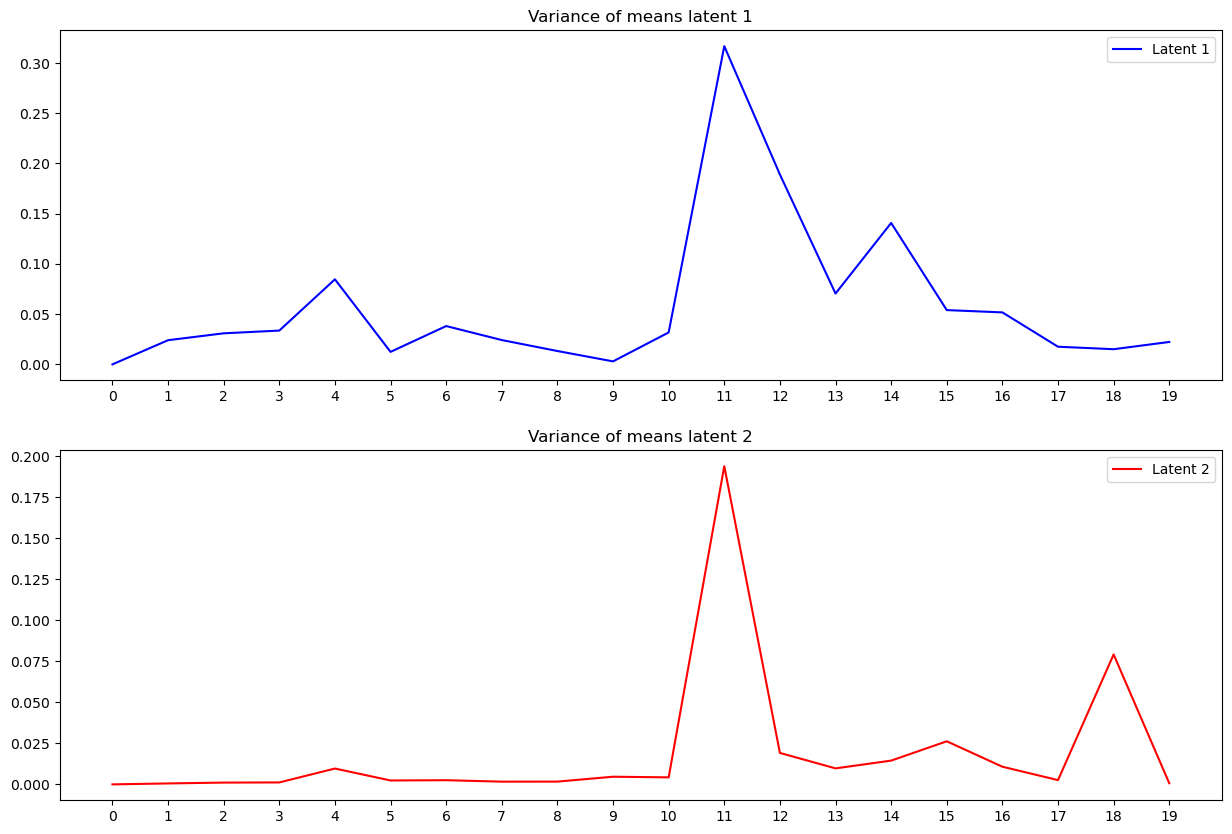

In [147]:
# Plot the variance of the means for each position
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(list(vars_pos.keys()), [vars_pos[i][0] for i in vars_pos.keys()], label='Latent 1', color='blue')
plt.title('Variance of means latent 1')
plt.xticks(np.arange(0, 20, 1))
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(list(vars_pos.keys()), [vars_pos[i][1] for i in vars_pos.keys()], label='Latent 2', color='red')
plt.title('Variance of means latent 2')
plt.xticks(np.arange(0, 20, 1))
plt.legend()
plt.show()

In [114]:
list(df["CDR3_al"].unique())

['CASSI-------RSSYEQYF',
 'CASSDR---TGAFTTGELFF',
 'CASNL-----LAGGQNEQFF',
 'CASSD-----QGSGANVLTF',
 'CASSW-------RAANEQFF',
 'CATSSE---RVRRYTGELFF',
 'CASSQ---------QREQYF',
 'CSASS------ESSYNEQFF',
 'CASSL-------AGAYEQYF',
 'CASTP--------GYTEAFF',
 'CASSD---------QGEQYF',
 'CASSL------WPATDTQYF',
 'CASSL--------AGAGYTF',
 'CASYS--------MNTEAFF',
 'CASSS----TGTGDAQPQHF',
 'CASSY-------GGRDGYTF',
 'CASSV------VLAEDTQYF',
 'CASSG----GTSGTLYEQYF',
 'CASSI-------RSAYEQYF',
 'CASSI-----GRLAGVEQFF',
 'CASRP----FGGTGRETQYF',
 'CASSL-----SYRGNTEAFF',
 'CASSFP---PSGRSTDEQYF',
 'CASSL--------AGVEQYF',
 'CASRG-----LASSTDTQYF',
 'CSVGL-------ASTYEQYF',
 'CASSG-------RSTDTQYF',
 'CASSL-----LAGGLNEQFF',
 'CASSE--------GSYEQYF',
 'CASSD----SRGPIPYEQYF',
 'CASSL----LAGGPPDTQYF',
 'CASSL-------SSTGELFF',
 'CASSL-----AGGPYNEQFF',
 'CASSW-------TGNNEQFF',
 'CASSQT---RQSSYNSPLHF',
 'CASSL-----AGGSHTEAFF',
 'CASST-------TGVDEQYF',
 'CASSS--------GTGEAFF',
 'CASSL--------GGETQYF',
 'CSQGR------MSSYNEQFF',


In [116]:
# Print full value counts of CDR3s
df["CDR3_al"].value_counts()

CASSI-------RSSYEQYF    13224
CASSL-------AGAYEQYF     7735
CASSI-------RSAYEQYF     1260
CASSL-----SYRGNTEAFF      361
CASSL--------AGVGYTF      289
                        ...  
CASSPR---VESFSTDTQYF        1
CASSP------DGEADTQYF        1
CASSI-------AGLGEQFF        1
CASRS---------FGELFF        1
CATSR------DKGGSVAFF        1
Name: CDR3_al, Length: 15115, dtype: int64

In [121]:
# Get most influential letter for each position
for pos in range(20):
    print("Position:", pos)
    pos_list_1 = []
    pos_list_2 = []
    for letter in aa:
        pos_list_1.append(store_dict["-" * pos + letter + "-" * (19 - pos)][0][0])
        pos_list_2.append(store_dict["-" * pos + letter + "-" * (19 - pos)][0][1])
    print("Highest abs value letter for latent 1: ", aa[np.argmax(np.abs(pos_list_1))])
    print("Highest abs value letter for latent 2: ", aa[np.argmax(np.abs(pos_list_2))])

Position: 0
Highest abs value letter for latent 1:  G
Highest abs value letter for latent 2:  T
Position: 1
Highest abs value letter for latent 1:  A
Highest abs value letter for latent 2:  -
Position: 2
Highest abs value letter for latent 1:  V
Highest abs value letter for latent 2:  -
Position: 3
Highest abs value letter for latent 1:  K
Highest abs value letter for latent 2:  -
Position: 4
Highest abs value letter for latent 1:  I
Highest abs value letter for latent 2:  I
Position: 5
Highest abs value letter for latent 1:  -
Highest abs value letter for latent 2:  -
Position: 6
Highest abs value letter for latent 1:  R
Highest abs value letter for latent 2:  L
Position: 7
Highest abs value letter for latent 1:  R
Highest abs value letter for latent 2:  S
Position: 8
Highest abs value letter for latent 1:  T
Highest abs value letter for latent 2:  N
Position: 9
Highest abs value letter for latent 1:  V
Highest abs value letter for latent 2:  -
Position: 10
Highest abs value letter fo